# Find suitable detector params for each parking

In [1]:
import random
import numpy
from datetime import datetime
from src.data.ParkingProvider import NoSpacesException, NoImageException
from src.metrics.PerformanceMetricsProviderSklearn import PerformanceMetricsProviderSklearn
from src.metrics.entity.PerformanceMetrics import PerformanceMetrics
from src.detector.entity.DetectionParams import DetectionParams
from src.data.ParkingProviderLocal import ParkingProviderLocalParams,ParkingProviderLocal
from src.app.ParkingOccupancyProcessorLocal import ParkingOccupancyProcessorLocal
from src.detector.OccupancyDetectorBorders import OccupancyDetectorBorders
import cv2 as cv

metrics_list = list()
row_names = list()
random_seed = datetime.now().timestamp

def test_parking(parking_id, detection_params:DetectionParams, row_name, process_batch=False):
    metrics_provider: PerformanceMetricsProviderSklearn = PerformanceMetricsProviderSklearn()

    provider_params = ParkingProviderLocalParams(
    parking_id=parking_id, path='E:\\Documents\\PKLot\\PKLot\\PKLot\\PKLot\\'+parking_id, k=4, random_seed=random_seed)
    
    processor = ParkingOccupancyProcessorLocal(
        parking_provider_params=provider_params, detection_params=detection_params, performance_metrics_provider=metrics_provider)

    if process_batch:
        try:
            detection_params.show_imshow=False
            processor.process_batch()
        except (NoSpacesException, NoImageException) as ex:
            print(f"Finished processing samples: ", ex)

    else:
        while True:
            try:
                processor.process()
            except (NoSpacesException, NoImageException) as ex:
                print(f"Finished processing samples: ", ex)
                break
        
    metrics_provider.calculate_metrics()
    metrics_provider.show_confusion_matrix()

    metrics_list.append(metrics_provider.metrics)
    row_names.append(row_name)
    
def setup_params(parking_id, initial_params:DetectionParams=None):
    provider_params = ParkingProviderLocalParams(
        parking_id=parking_id, path='E:\\Documents\\PKLot\\PKLot\\PKLot\\PKLot\\'+parking_id, k=200)

    parking_provider = ParkingProviderLocal(provider_params)

    # metrics: PerformanceMetricsProviderSklearn = PerformanceMetricsProviderSklearn()

    # processor = ParkingOccupancyProcessorLocal(
    #     parking_provider_params=provider_params, detection_params=PARAMS_UFPR04, performance_metrics_provider=metrics)

    try:
        params = initial_params
        while True:
        # while (it > 0 and i < it) or it < 0:
        #     i = i+1
        #     print(f"Processing sample: {str(i)}")
        #     processor.process()

            parking = parking_provider.get_parking()
            img = parking.image
            spaces = parking.spaces

            params = OccupancyDetectorBorders.setup_params_img(img, spaces, params)

            
            cv.namedWindow("Press ESC to exit, other key to continue")
            key = cv.waitKey(0)
            if key == 27:
                cv.destroyAllWindows()
                break  
              
            cv.destroyAllWindows()
   
    except (NoSpacesException, NoImageException) as ex:
        print(f"Finished processing: ", ex)
    finally:
        return params
    

## UFPR04

In [2]:
p = setup_params('UFPR04')
p.show_imshow=True
print(p)

# PARAMS_UFPR04 = DetectionParams((5, 5), 0, cv.ADAPTIVE_THRESH_GAUSSIAN_C, at_blockSize=31, at_C=10, median_k=3, bw_size=50, vacant_threshold=0.3, show_imshow=True)  # UFPR04
test_parking('UFPR04', p, 'UFPR04 selected params',True)

  7%|▋         | 5/75 [00:03<00:42,  1.66it/s]


## UFPR05

Selected 1038 files
Processing 1038 files with 16 cores


100%|██████████| 1038/1038 [01:07<00:00, 15.41it/s]


Precision: 0.856
specificity: 0.897
Recall: 0.869
F1 Score: 0.863
Accuracy: 0.886


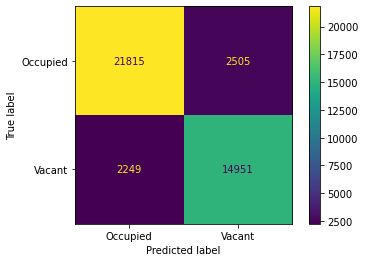

In [3]:
PARAMS_UFPR05 = DetectionParams(gb_k=(5, 5), gb_s=0, at_method=cv.ADAPTIVE_THRESH_GAUSSIAN_C, at_blockSize=33, at_C=9, median_k=3, bw_size=20, vacant_threshold=0.26, show_imshow=False)
# p = setup_params('UFPR05', PARAMS_UFPR05)
# p.show_imshow=True
# print(p)

test_parking('UFPR05', PARAMS_UFPR05, 'UFPR05 selected params', process_batch=True)


Selected 1038 files
Processing 1038 files with 16 cores


100%|██████████| 1038/1038 [02:01<00:00,  8.54it/s]

Precision: 0.855
specificity: 0.901
Recall: 0.828
F1 Score: 0.841
Accuracy: 0.871


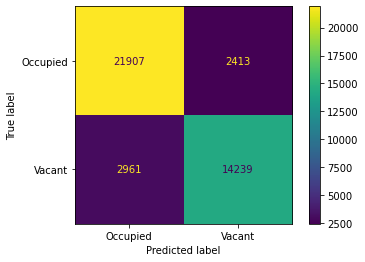

In [4]:
# p = setup_params('UFPR05', PARAMS_UFPR05)
# p.show_imshow=True
# print(p)

PARAMS_UFPR05 = DetectionParams(gb_k=(5, 5), gb_s=0, at_method=cv.ADAPTIVE_THRESH_GAUSSIAN_C, at_blockSize=33, at_C=7, median_k=3, bw_size=85, vacant_threshold=0.3, show_imshow=True)
test_parking('UFPR05', PARAMS_UFPR05, 'UFPR05 params 2', process_batch=True)

Selected 1038 files
Processing 1038 files with 16 cores


100%|██████████| 1038/1038 [01:51<00:00,  9.33it/s]


Precision: 0.797
specificity: 0.836
Recall: 0.915
F1 Score: 0.852
Accuracy: 0.868


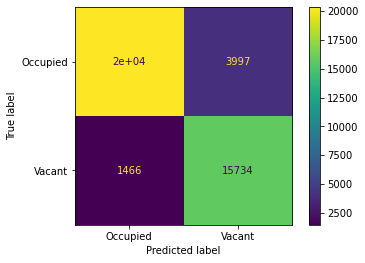

In [5]:
PARAMS_UFPR05 = DetectionParams(gb_k=(5, 5), gb_s=0, at_method=cv.ADAPTIVE_THRESH_GAUSSIAN_C, at_blockSize=33, at_C=9, median_k=3, bw_size=300, vacant_threshold=0.22, show_imshow=True)
# p = setup_params('UFPR05', PARAMS_UFPR05)
# p.show_imshow=True
# print(p)

test_parking('UFPR05', PARAMS_UFPR05, 'UFPR05 params 3', process_batch=True)

In [6]:
PerformanceMetricsProviderSklearn.show_dataframe(metrics_list, row_names)


                        precision  specificity  recall     f1  accuracy
UFPR05 selected params      0.856        0.897   0.869  0.863     0.886
UFPR05 params 2             0.855        0.901   0.828  0.841     0.871
UFPR05 params 3             0.797        0.836   0.915  0.852     0.868


## PUCPR

In [ ]:
# from ipynb.fs.full.functions import *
%run "ParkingSpaceDetector.py"
import random
import glob

path = 'E:/Documents/PKLot/PKLot/PKLot/PKLot/UFPR04'
# Get all images in path
files = glob.glob(path + '/**/*.jpg', recursive=True)
# Select n random images from dataset
selected_files = random.choices(files, k=int(len(files)/10))

# params = DetectionParams((5,5), 0, cv.ADAPTIVE_THRESH_GAUSSIAN_C, 27, 7, 3, 85) # PUCPR
# params = DetectionParams((5,5), 0, cv.ADAPTIVE_THRESH_GAUSSIAN_C, 33, 7, 3, 85) # UPR05



In [ ]:
# Setup detection params
img = cv.imread(selected_files[0]) 
setup_preprocess(img)


In [ ]:
# Step by step detection
gaussianBlurKernel = (3, 3)  # Tamaño kernel suavizado gaussiano
gaussianBlurSigma = 0
at_blockSize = 41           # Tamaño vecindad umbral adaptativo
at_C = 11                    # Constante a sustraer en el umbral adaptativo
median_k = 3                # Tamaño kernel filtro mediana
bw_size = 104                # Umbral Eliminar objetos pequeños
params = DetectionParams(gaussianBlurKernel, gaussianBlurSigma,
                         cv.ADAPTIVE_THRESH_GAUSSIAN_C, at_blockSize, at_C, median_k, bw_size, vacant_threshold=0.25, show_imshow=False)  # UFPR04

confusion_matrix = detect_batch(selected_files, params)

In [ ]:
# Step by step detection
gaussianBlurKernel = (3, 3)  # Tamaño kernel suavizado gaussiano
gaussianBlurSigma = 0
at_blockSize = 41           # Tamaño vecindad umbral adaptativo
at_C = 11                    # Constante a sustraer en el umbral adaptativo
median_k = 3                # Tamaño kernel filtro mediana
bw_size = 104                # Umbral Eliminar objetos pequeños
params = DetectionParams(gaussianBlurKernel, gaussianBlurSigma,
                         cv.ADAPTIVE_THRESH_GAUSSIAN_C, at_blockSize, at_C, median_k, bw_size, vacant_threshold=0.25, show_imshow=False)  # UFPR04
confusion_matrix, real, predicted = process_batch(selected_files, params)
precision, specificity, recall, f1, accuracy = show_confusion_matrix(confusion_matrix, real, predicted)

In [ ]:
# W/o median filter
gaussianBlurKernel = (3, 3)  # Tamaño kernel suavizado gaussiano
gaussianBlurSigma = 0
at_blockSize = 31           # Tamaño vecindad umbral adaptativo
at_C = 13                    # Constante a sustraer en el umbral adaptativo
median_k = -1                # Tamaño kernel filtro mediana
bw_size = 30                # Umbral Eliminar objetos pequeños
vacant_threshold = 0.25     # Umbral área del hueco para ser considerado ocupado
params = DetectionParams(gaussianBlurKernel, gaussianBlurSigma,
                         cv.ADAPTIVE_THRESH_GAUSSIAN_C, at_blockSize, at_C, median_k, bw_size, vacant_threshold, show_imshow=True)  # UFPR04

confusion_matrix, real, predicted = process_batch(selected_files, params)
precision, specificity, recall, f1, accuracy = show_confusion_matrix(confusion_matrix, real, predicted)

In [ ]:
# W median filter
# Gaussian blur filter kernel = 3x3
# at_blockSize 31
gaussianBlurKernel = (3, 3)  # Tamaño kernel suavizado gaussiano
gaussianBlurSigma = 0
at_blockSize = 31           # Tamaño vecindad umbral adaptativo
at_C = 13                    # Constante a sustraer en el umbral adaptativo
median_k = 3                # Tamaño kernel filtro mediana
bw_size = 30                # Umbral Eliminar objetos pequeños
vacant_threshold = 0.25     # Umbral área del hueco para ser considerado ocupado
params = DetectionParams(gaussianBlurKernel, gaussianBlurSigma,
                         cv.ADAPTIVE_THRESH_GAUSSIAN_C, at_blockSize, at_C, median_k, bw_size, vacant_threshold, show_imshow=False)  # UFPR04

confusion_matrix, real, predicted = process_batch(selected_files, params)
precision, specificity, recall, f1, accuracy = show_confusion_matrix(confusion_matrix, real, predicted)

In [ ]:
# W median filter
# Gaussian blur filter kernel = 5x5
# at_blockSize 29
gaussianBlurKernel = (5, 5)  # Tamaño kernel suavizado gaussiano
gaussianBlurSigma = 0
at_blockSize = 29           # Tamaño vecindad umbral adaptativo
at_C = 8                    # Constante a sustraer en el umbral adaptativo
median_k = 3                # Tamaño kernel filtro mediana
bw_size = 23                # Umbral Eliminar objetos pequeños
vacant_threshold = 0.25     # Umbral área del hueco para ser considerado ocupado
params = DetectionParams(gaussianBlurKernel, gaussianBlurSigma,
                         cv.ADAPTIVE_THRESH_GAUSSIAN_C, at_blockSize, at_C, median_k, bw_size, vacant_threshold)  # UFPR04

confusion_matrix, real, predicted = process_batch(selected_files, params)
show_confusion_matrix(confusion_matrix, real, predicted)

In [ ]:
gaussianBlurKernel = (5, 5)  # Tamaño kernel suavizado gaussiano
gaussianBlurSigma = 0
at_blockSize = 29           # Tamaño vecindad umbral adaptativo
at_C = 8                    # Constante a sustraer en el umbral adaptativo
median_k = 3                # Tamaño kernel filtro mediana
bw_size = 23                # Umbral Eliminar objetos pequeños
vacant_threshold = 0.25     # Umbral área del hueco para ser considerado ocupado
params = DetectionParams(gaussianBlurKernel, gaussianBlurSigma,
                         cv.ADAPTIVE_THRESH_GAUSSIAN_C, at_blockSize, at_C, median_k, bw_size, vacant_threshold)  # UFPR04

confusion_matrix, real, predicted = process_batch(selected_files, params)
show_confusion_matrix(confusion_matrix, real, predicted)

In [ ]:
gaussianBlurKernel = (5,5)  # Tamaño kernel suavizado gaussiano
gaussianBlurSigma = 0
at_blockSize = 29           # Tamaño vecindad umbral adaptativo
at_C = 10                    # Constante a sustraer en el umbral adaptativo
median_k = 3                # Tamaño kernel filtro mediana
bw_size = 25                # Umbral Eliminar objetos pequeños 
vacant_threshold = 0.25     # Umbral área del hueco para ser considerado ocupado

params = DetectionParams(gaussianBlurKernel, gaussianBlurSigma, cv.ADAPTIVE_THRESH_GAUSSIAN_C, at_blockSize, at_C, median_k, bw_size, vacant_threshold) # UFPR04

confusion_matrix, real, predicted = process_batch(selected_files, params)
show_confusion_matrix(confusion_matrix, real, predicted)

## PUCPR

In [ ]:
from ipynb.fs.full.ParkingSpaceDetector import *
import random
import glob

path = 'E:/\Documents\\PKLot\\PKLot\\PKLot\\PKLot\\PUCPR'
files = glob.glob(path+ '/**/*.jpg', recursive=True)            # Get all images in path
selected_files = random.choices(files, k=int(len(files)/10))    # Select n random images from dataset

In [ ]:
params = DetectionParams((5,5), 0, cv.ADAPTIVE_THRESH_GAUSSIAN_C, 27, 7, 3, 85) # PUCPR
confusion_matrix, real, predicted = process_batch(selected_files, params,  vacant_threshold=0.26)
show_confusion_matrix(confusion_matrix, real, predicted)

## UPR05

In [ ]:
from ipynb.fs.full.ParkingSpaceDetector import *
import random
import glob

# params = DetectionParams((5,5), 0, cv.ADAPTIVE_THRESH_GAUSSIAN_C, 33, 7, 3, 85) # UPR05
path = 'E:\\Documents\\PKLot\\PKLot\\PKLot\\PKLot\\UFPR05'
files = glob.glob(path+ '/**/*.jpg', recursive=True)            # Get all images in path
selected_files = random.choices(files, k=int(len(files)/10))    # Select n random images from dataset

In [ ]:
params = DetectionParams((5,5), 0, cv.ADAPTIVE_THRESH_GAUSSIAN_C, 33, 9, 3, 305) # UPR05
confusion_matrix, real, predicted = process_batch(selected_files, params,  vacant_threshold=0.22)
show_confusion_matrix(confusion_matrix, real, predicted)